# Generating Tom Cruise Images with DQD Algorithms

_Lights! Camera! Action!_ 📸

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

In recent years, there has been an explosion in AI's ability to understand and manipulate images and text. In particular, with the rise of [Generative Adversarial Networks (GANs)](https://en.wikipedia.org/wiki/Generative_adversarial_network) like [StyleGAN](https://en.wikipedia.org/wiki/StyleGAN), AI can now generate fake yet highly realistic images. Incredibly, even something as complex as a human face can now be reproduced with ease, as demonstrated by websites like [this person does not exist](https://thispersondoesnotexist.com) and [which face is real](https://www.whichfaceisreal.com/index.php).

Yet, one problem which GANs face is that they can be difficult to control. For instance, suppose we wanted to generate an image of a specific person, say, a famous celebrity like Tom Cruise. To accomplish this task, we would need to find a latent vector $z$, such that when we pass $z$ into the GAN's generator, the generator outputs an image of the actor. However, finding $z$ is not straightforward. Typical GAN latent spaces are not interpretable, i.e., there is no sign saying "use this $z$ to get an image of Tom Cruise." Hence, we would have to try at least a few vectors. But trying out all these vectors brings us to our second problem: how do we check that the images we generate actually show Tom Cruise? Surely, we can't sit around looking at every single image created — Tom Cruise will have filmed his next movie by then!

Fortunately, this is where another major advance in AI comes in. At the same time that GANs have learned to generate all kinds of fake images, models like [CLIP](https://openai.com/blog/clip/) have learned to seamlessly associate text with images. Essentially, CLIP takes in a piece of text (a "prompt") and an image and tells how similar they are. And this is exactly what we need for our problem: given the prompt "Tom Cruise" and an image generated by our GAN, CLIP will tell us whether the image indeed shows our beloved actor.

The diagram below demonstrates this pipeline. We pass a latent vector $z$ to StyleGAN (our choice of GAN), then we pass the output of StyleGAN to CLIP along with the prompt "Tom Cruise." CLIP outputs a score, and once we backpropagate through the networks, we get a gradient $\nabla_z f$. By performing gradient descent, we can update $z$ so that we gradually generate more realistic images of Tom Cruise. Such a pipeline has been successfully implemented in this wonderful [blog post](https://towardsdatascience.com/generating-images-from-prompts-using-clip-and-stylegan-1f9ed495ddda) by Victor Perez.

![The StyleGAN+CLIP Pipeline](_static/stylegan-clip.png)

While this pipeline works splendidly, it has a key limitation, in that it can only generate one picture at a time. Yet, we know there are many possible images of Tom Cruise; for instance, he has sported different hairstyles throughout his long acting career.

That's where the concept of latent space illumination (LSI) comes in. [Introduced in 2021](https://arxiv.org/abs/2007.05674), LSI  uses QD algorithms to search for a diverse collection of images in a GAN's latent space. To frame our current problem as a QD problem, we can set our objective to be to find an image of Tom Cruise, and we can set our measures to be (1) the length of Tom Cruise's hair and (2) the age of Tom Cruise, with the measures computed with CLIP just like the objective is. By solving this QD problem, we will create an archive consisting of different images of Tom Cruise, like the one shown below.

![Outputs of an LSI algorithm searching for images of Tom Cruise](_static/tom-cruise-archive.png)

Given what we know so far, we could perform LSI with CMA-ME or CMA-MAE. However, an important property of this problem is that the objective and measures are differentiable — recall that the original pipeline above used gradient descent to modify $z$. [Fontaine 2021](https://arxiv.org/abs/2106.03894) formalizes this type of problem as a differentiable quality diversity (DQD) problem, i.e., a QD problem where the objective and measure functions are first-order differentiable. Compared to derivative-free algorithms like CMA-ME and CMA-MAE, DQD algorithms are typically much more efficient, as they are able to leverage gradients to guide themselves around the search space.

In this tutorial, we will apply DQD algorithms to search for images of Tom Cruise. Specifically, we will implement the DQD algorithm Covariance Matrix Adaptation MAP-Annealing via a Gradient Arborescence (CMA-MAEGA), introduced in [Fontaine 2022](https://arxiv.org/abs/2205.10752), and run it with the StyleGAN+CLIP pipeline described above.

_This tutorial assumes that you are familiar with Covariance Matrix Adaptation MAP-Elites (CMA-ME). If you are not yet familiar with CMA-ME, we recommend reviewing our [Lunar Lander tutorial](https://docs.pyribs.org/en/stable/tutorials/lunar_lander.html). And for more on latent space illumination, refer to our [LSI MNIST tutorial](https://docs.pyribs.org/en/stable/tutorials/lsi_mnist.html) which generates diverse MNIST digits._

## Setup

Since StyleGAN and CLIP are fairly large models, you will need a GPU to run this tutorial. On Colab, activate the GPU by clicking "Runtime" in the toolbar at the top. Then, click "Change Runtime Type", and select "GPU".

Below, we check what GPU has been provided. The possible GPUs (at the time of writing) are as follows; factory reset the runtime if you do not have a desired GPU.

* V100 = Excellent (*Available only for Colab Pro users*)
* P100 = Very Good
* T4 = Good (*preferred*)
* K80 = Meh
* P4 = (*Not Recommended*) 

In [26]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-eedb9df7-bfbe-cdca-51a7-07032e623eaa)


Now, we install various libraries, including pyribs, CLIP, and StyleGAN 2. This cell will take around 5 minutes to run since it involves downloading multiple large files.

In [ ]:
# PyTorch
%pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# CLIP
!git clone https://github.com/openai/CLIP
%pip install -e ./CLIP

# StyleGAN
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!curl -LO 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-256x256.pkl'

# pyribs and others
%pip install ribs einops ninja timm

# Add libraries to the system path.
import sys
sys.path.append("./CLIP")
sys.path.append("./stylegan2-ada-pytorch")

And below, we import several libraries we will be using in this tutorial.

In [28]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import torch
import torch.nn.functional as F

from IPython.display import display
from PIL import Image
from einops import rearrange
from pathlib import Path
from torchvision.utils import make_grid
from tqdm import tqdm, trange

Finally, let's set up CUDA for PyTorch.

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)

cuda


## Preliminaries: StyleGAN and CLIP

Below we set up StyleGAN and CLIP. The code for these two models is adopted from Victor Perez's [blog post](https://towardsdatascience.com/generating-images-from-prompts-using-clip-and-stylegan-1f9ed495ddda), the [VQ-GAN+CLIP paper](https://arxiv.org/abs/2204.08583), and the [StyleGAN3+CLIP notebook](https://colab.research.google.com/github/ouhenio/StyleGAN3-CLIP-notebooks/blob/main/StyleGAN3+CLIP.ipynb).

*Since this section is focused on the StyleGAN+CLIP pipeline rather than on pyribs, feel free to skim past and come back to it later.*

### CLIP for Connecting Text and Images

In [30]:
import clip
import torchvision.transforms as transforms

def norm1(prompt):
    return prompt / prompt.square().sum(dim=-1, keepdim=True).sqrt()

class CLIP:
    """Manages a CLIP model."""

    def __init__(self, clip_model_name = "ViT-B/32", device='cpu'):
        self.device = device
        self.model, _ = clip.load(clip_model_name, device=device)
        self.model = self.model.requires_grad_(False)
        self.model.eval()
        self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                              std=[0.26862954, 0.26130258, 0.27577711])
        self.transform = transforms.CenterCrop(224)

    @torch.no_grad()
    def embed_text(self, prompt):
        return norm1(self.model.encode_text(clip.tokenize(prompt)
               .to(self.device)).float())

    def embed_cutout(self, image):
        return norm1(self.model.encode_image(self.normalize(image)))

    def embed_image(self, image):
        n = image.shape[0]
        centered_img = self.transform(image)
        embeds = self.embed_cutout(centered_img)
        embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
        return embeds

### StyleGAN 2 for Generating Images

In [31]:
class Generator:
    """Manages a StyleGAN2 model."""

    def __init__(self, device='cpu'):
        self.device = device
        model_filename = './stylegan2-ffhq-256x256.pkl'
        with open(model_filename, 'rb') as fp:
            self.model = pickle.load(fp)['G_ema'].to(device)
            self.model.eval()
        for p in self.model.parameters():
            p.requires_grad_(False)
        self.init_stats()
        self.latent_shape = (-1, 512)

    def init_stats(self):
        zs = torch.randn([10000, self.model.mapping.z_dim], device=self.device)
        ws = self.model.mapping(zs, None)
        self.w_stds = ws.std(0)
        qs = ((ws - self.model.mapping.w_avg) / self.w_stds).reshape(10000, -1)
        self.q_norm = torch.norm(qs, dim=1).mean() * 0.35

    def gen_random_ws(self, num_latents):
        zs = torch.randn([num_latents, self.model.mapping.z_dim], device=self.device)
        ws = self.model.mapping(zs, None)
        return ws

### Classifier for Computing Objectives and Measures

We define a `Classifier` which manages the Generator and CLIP model in order to compute the relevant objectives and measures. The `Classifier` takes in a prompt, e.g., "Tom Cruise." The objective is then "A photo of Tom Cruise," while the measures are the age and hair length of Tom Cruise. Each measure is determined by two opposite prompts, i.e., age is determined by "A photo of Tom Cruise as a small child" and "A photo of Tom Cruise as an elderly person," while hair length is determined by "A photo of Tom Cruise with long hair" and "A photo of Tom Cruise with short hair."

Refer to Appendix I of [Fontaine 2022](https://arxiv.org/abs/2205.10752) to get a better understanding of the tricks involved in handling StyleGAN and CLIP together.

In [32]:
def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def cos_sim_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().mul(2)

def prompts_dist_loss(x, targets, loss):
    if len(targets) == 1: # Keeps consistent results vs previous method for single objective guidance 
      return loss(x, targets[0])
    distances = [loss(x, target) for target in targets]
    loss = torch.stack(distances, dim=-1).sum(dim=-1)
    return loss

def transform_obj(objs):
    """Remaps the CLIP objective so that it is maximizing the range [0, 100]."""
    return (10.0 - objs * 5.0) * 10.0

class Classifier:

    def __init__(self, gen_model, class_model, prompt):
        self.device = gen_model.device
        self.gen_model = gen_model
        self.class_model = class_model

        self.init_objective(f'A photo of the face of {prompt}.')
        
        # Prompts for the measures. Modify these to search for different
        # ranges of images.
        self.measures = []
        self.add_measure(f'A photo of {prompt} as a small child.', 
                         f'A photo of {prompt} as an elderly person.')
        self.add_measure(f'A photo of {prompt} with long hair.', 
                         f'A photo of {prompt} with short hair.')

    def init_objective(self, text_prompt):
        texts = [frase.strip() for frase in text_prompt.split("|") if frase]
        self.obj_targets = [self.class_model.embed_text(text) for text in texts]

    def add_measure(self, positive_text, negative_text):
        texts = [frase.strip() for frase in positive_text.split("|") if frase]
        negative_targets = [self.class_model.embed_text(text) for text in texts]
        
        texts = [frase.strip() for frase in negative_text.split("|") if frase]
        positive_targets = [self.class_model.embed_text(text) for text in texts]
        
        self.measures.append((negative_targets, positive_targets))

    def find_good_start_latent(self, batch_size=16, num_batches=32):
        with torch.inference_mode():
            qs = []
            losses = []
            G = self.gen_model.model
            w_stds = self.gen_model.w_stds
            for _ in range(num_batches):
                q = (G.mapping(torch.randn([batch_size, G.mapping.z_dim], device=self.device),
                    None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
                images = G.synthesis(q * w_stds + G.mapping.w_avg)
                embeds = self.class_model.embed_image(images.add(1).div(2))
                loss = prompts_dist_loss(embeds, self.obj_targets, spherical_dist_loss).mean(0)
                i = torch.argmin(loss)
                qs.append(q[i])
                losses.append(loss[i])
            qs = torch.stack(qs)
            losses = torch.stack(losses)

            i = torch.argmin(losses)
            q = qs[i].unsqueeze(0)

        return q.flatten()

    def generate_image(self, latent_code):
        ws, _ = self.transform_to_w([latent_code])
        images = self.gen_model.model.synthesis(ws, noise_mode='const')
        return images

    def transform_to_w(self, latent_codes):
        qs = []
        ws = []
        for cur_code in latent_codes:
            q = torch.tensor(
                    cur_code.reshape(self.gen_model.latent_shape), 
                    device=self.device,
                    requires_grad=True,
                )
            qs.append(q)
            w = q * self.gen_model.w_stds + self.gen_model.model.mapping.w_avg
            ws.append(w)

        ws = torch.stack(ws, dim=0)
        return ws, qs

    def compute_objective_loss(self, embeds, qs, dim=None):
        loss = prompts_dist_loss(embeds, self.obj_targets, spherical_dist_loss).mean(0)

        diff = torch.max(torch.norm(qs, dim=dim), self.gen_model.q_norm)
        reg_loss = (diff - self.gen_model.q_norm).pow(2)
        loss = loss + 0.2* reg_loss

        return loss

    def compute_objective(self, sols):
        ws, qs = self.transform_to_w(sols)

        images = self.gen_model.model.synthesis(ws, noise_mode='const')
        embeds = self.class_model.embed_image(images.add(1).div(2))
    
        loss = self.compute_objective_loss(embeds, qs[0])
        loss.backward()

        value = loss.cpu().detach().numpy()
        jacobian = -qs[0].grad.cpu().detach().numpy()
        return (
            transform_obj(value),
            jacobian.flatten(),
        )

    def compute_measure(self, index, sols):
        """Computes a *single* measure and its gradient."""
        ws, qs = self.transform_to_w(sols)

        images = self.gen_model.model.synthesis(ws, noise_mode='const')
        embeds = self.class_model.embed_image(images.add(1).div(2))

        measure_targets = self.measures[index]
        pos_loss = prompts_dist_loss(embeds, measure_targets[0], cos_sim_loss).mean(0)
        neg_loss = prompts_dist_loss(embeds, measure_targets[1], cos_sim_loss).mean(0)
        loss = pos_loss - neg_loss
        loss.backward()

        value = loss.cpu().detach().numpy()
        jacobian = qs[0].grad.cpu().detach().numpy()
        return (
            value,
            jacobian.flatten(),
        )

    def compute_measures(self, sols):
        """Computes *all* measures and their gradients."""
        values = []
        jacobian = []
        for i in range(len(self.measures)):
            value, jac = self.compute_measure(i, sols)
            values.append(value)
            jacobian.append(jac)

        return (
            np.stack(values, axis=0),
            np.stack(jacobian, axis=0),
        )

    def compute_all_no_grad(self, sols):
        """Computes the objective and measure without gradients."""
        with torch.inference_mode():

            ws, qs = self.transform_to_w(sols)
            qs = torch.stack(qs, dim=0)

            images = self.gen_model.model.synthesis(ws, noise_mode='const')
            embeds = self.class_model.embed_image(images.add(1).div(2))
            
            loss = self.compute_objective_loss(embeds, qs, dim=(1,2))
            objective_batch = loss.cpu().detach().numpy()

            measures_batch = []
            for i in range(len(self.measures)):
                measure_targets = self.measures[i]
                pos_loss = prompts_dist_loss(
                        embeds, 
                        measure_targets[0], 
                        cos_sim_loss,
                    ).mean(0)
                neg_loss = prompts_dist_loss(
                        embeds, 
                        measure_targets[1], 
                        cos_sim_loss
                    ).mean(0)
                loss = pos_loss - neg_loss
                value = loss.cpu().detach().numpy()
                measures_batch.append(value)

        return (
            transform_obj(objective_batch),
            np.stack(measures_batch, axis=0).T
        )

## Celebrity Selection

Finally, we set up our models to handle a given celebrity. On Colab, the code below should show a prompt where you can enter the celebrity of your choice. If running locally, you will need to manually alter the `prompt` variable.

In [33]:
#@markdown `prompt`: Enter a prompt of a Celebrity here to guide the image generation.

prompt = "Tom Cruise" #@param {type:"string"}

clip_model = CLIP(device=device)
gen_model = Generator(device=device)
classifier = Classifier(gen_model, clip_model, prompt=prompt)

## CMA-MAEGA with pyribs

To search for images of Tom Cruise, we will use Covariance Matrix Adaptation MAP-Annealing via a Gradient Arborescence (CMA-MAEGA) (please refer to [Fontaine 2021](https://arxiv.org/abs/2106.03894) and [Fontaine 2022](https://arxiv.org/abs/2205.10752) if you are not yet familiar with CMA-MAEGA). Similar to CMA-ME (see the [lunar lander tutorial](https://docs.pyribs.org/en/latest/tutorials/lunar_lander.html)) and CMA-MAE (see the [CMA-MAE tutorial](https://docs.pyribs.org/en/latest/tutorials/cma_mae.html)), CMA-MAEGA requires a `GridArchive` and `Scheduler`, but while CMA-ME and CMA-MAE use an `EvolutionStrategyEmitter`, CMA-MAEGA uses a `GradientArborescenceEmitter`.

### GridArchive

First, we create the [`GridArchive`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html). The archive is 200x200 and stores StyleGAN latent vectors which are 7,168-dimensional.

The `ranges` (i.e. bounds of the measure space) effectively control the solution space from which our pipeline generates images. Widening the ranges will result in generating more exotic images, while narrowing the ranges will focus the search into a tight window.

Similar to CMA-MAE, this archive takes in `learning_rate` and `threshold_min` parameters. `learning_rate` ($\alpha$) controls how quickly the threshold in each cell is updated, and we set this to 0.02. Meanwhile, `threshold_min` ($min_f$) is the starting threshold for each cell. This threshold is typically the minimum objective in the problem, hence we choose 0.0.

Finally, we set `dtype=np.float32` since PyTorch models operate with `float32` rather than the pyribs default of `float64`.

In [34]:
from ribs.archives import GridArchive

# This line may take a minute or two since it involves calling the classifier.
initial_sol = classifier.find_good_start_latent().cpu().detach().numpy()

dims = [200, 200]
ranges = [(-0.2, 0.2), (-0.2, 0.2)]

archive = GridArchive(
    solution_dim=len(initial_sol),
    dims=dims, 
    ranges=ranges, 
    learning_rate=0.02,
    threshold_min=0.0,
    dtype=np.float32,
)

In CMA-MAEGA, since solutions are added to the archive based on the **threshold** of each cell rather than on the **objective** of the elite in each cell, it is possible for CMA-MAEGA to make "backwards" progress. _Specifically, a solution's objective can exceed the cell's threshold value but not exceed the objective of the cell's current elite,_ which results in overwriting the **better** solution.

For this reason, CMA-MAEGA sometimes benefits from a separate **result archive** that keeps track of the best solutions encountered in each cell. The `GridArchive` does this by default since it has a default `learning_rate=1.0` and `threshold_min=-inf`. Hence, we create an archive below which is identical to the one above except that we do not set the `learning_rate` and `threshold_min`.

In [35]:
result_archive = GridArchive(
    solution_dim=len(initial_sol),
    dims=dims,
    ranges=ranges,
)

### GradientArborescenceEmitter

To solve DQD problems, [Fontaine et al., 2021](https://arxiv.org/abs/2106.03894) introduced the concept of a *gradient arborescence* which creates solutions by branching according to both objective and measure gradients.

Essentially, the `GradientArborescenceEmitter` leverages the gradient information of the objective and measure functions, generating new solutions around a *solution point* $\boldsymbol{\theta}$ using gradient arborescence with coefficients drawn from a Gaussian distribution. To elaborate, the emitter samples coefficients $\boldsymbol{c_i} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$ and creates new solutions $\boldsymbol{\theta'_i}$ according to

$$\boldsymbol{\theta'_i} \gets \boldsymbol{\theta} + c_{i,0} \boldsymbol{\nabla} f(\boldsymbol{\theta}) + \sum_{j=1}^k c_{i,j} \boldsymbol{\nabla} m_j(\boldsymbol{\theta})$$

Where $k$ is the number of measures, and $\boldsymbol{\nabla} f(\boldsymbol{\theta})$ and $\boldsymbol{\nabla} m_j(\boldsymbol{\theta})$ are the objective and measure gradients of the solution point $\boldsymbol{\theta}$, respectively.

Based on how the solutions are ranked after being inserted into the archive (see ``ranker``), the solution point $\boldsymbol{\theta}$ is updated with gradient ascent, and the coefficient distribution parameters $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ are updated with an ES (the default ES is CMA-ES).

Below we create a single `GradientArborescenceEmitter`. In the StyleGAN+CLIP pipeline, gradient computations are expensive because they require backpropagating through large neural networks. By using only one `GradientArborescenceEmiter`, we only have to perform one gradient computation per iteration.

In [36]:
from ribs.emitters import GradientArborescenceEmitter

emitters = [
    GradientArborescenceEmitter(
        archive=archive,
        x0=initial_sol,
        sigma0=0.01,  # Initial standard deviation for the coefficient distribution.
        lr=0.05,  # Learning rate for updating theta with gradient ascent.
        ranker="imp",
        selection_rule="mu",
        restart_rule='basic',
        batch_size=32,
    )
]

### Scheduler

Finally, the [`Scheduler`](https://docs.pyribs.org/en/latest/api/ribs.schedulers.Scheduler.html) controls how the emitters interact with the archive and result archive. On every iteration, the scheduler calls the emitters to generate solutions. After the user evaluates these generated solutions, the scheduler inserts the solutions into both the archive and result archive. It then passes feedback from the archive (but not the result archive) to the emitters. In this manner, the emitters only interact with the archive, but the result archive stores all the best solutions found by CMA-MAEGA.

In [37]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

### Summary: Differences from CMA-MEGA

Similar to how CMA-MAE builds on CMA-ME, CMA-MAEGA builds on Covariance Matrix Adaptation MAP-Elites via a Gradient Arborescence (CMA-MEGA) introduced in [Fontaine et al., 2021](https://arxiv.org/abs/2106.03894). Implementation-wise, these are the differences between CMA-MAEGA and CMA-MEGA in pyribs. They mirror the differences between CMA-MAE and CMA-ME in the [CMA-MAE tutorial](https://docs.pyribs.org/en/latest/tutorials/cma_mae.html).

* The archive (we used `GridArchive` but you can also use another archive) takes in a `learning_rate` and `threshold_min` parameter. The `learning_rate` is between 0 and 1 (inclusive), and the `threshold_min` typically corresponds to the minimum objective of the problem.
* A second result archive is created to store best solutions, as introducing thresholds means that the first archive is not guaranteed to store the best solutions. This archive is identical to the first, but it does not have `learning_rate` or `threshold_min` parameters.
* `GradientArborescenceEmitter` uses improvement ranking (`ranker="imp"`) rather than two-stage improvement ranking (`ranker="2imp"`).
* `GradientArborescenceEmitter` uses `selection_rule="mu"` and `restart_rule="basic"` instead of the default `selection_rule="filter"` and `restart_rule="no_improvement"`.
* `Scheduler` also takes in the `result_archive`.

Feel free to try out CMA-MEGA as well as different settings of these parameters; parameters such as `selection_rule` and `restart_rule` are more amenable to change and may affect the behavior of the resulting algorithm. The rest of this tutorial proceeds with CMA-MAEGA with the settings shown above.

## Latent Space Illumination with CMA-MAEGA and StyleGAN+CLIP

Having set up the necessary components above, we now run CMA-MAEGA to search for images of Tom Cruise (or another celebrity you specified above).

In pyribs, DQD algorithms add an additional phase before the normal calls to the scheduler's `ask()` and `tell()` methods. This extra phase consists of calls to `ask_dqd()` and `tell_dqd()` and allows the emitters to generate solutions which require gradient computations.

Thus, the full execution loop consists of two phases. In the first phase, we request the solution point from the emitter by calling the scheduler's `ask_dqd()` method. Then, we use the StyleGAN+CLIP pipeline to compute the objective, measures, and their gradients, and we pass this solution point back to the scheduler with `tell_dqd()`. In the second phase, we call the scheduler's `ask()` method to request solutions which the emitter branched from the solution point by gradient arborescence. We then evaluate the objectives and measures of these solutions (without computing gradients) and pass them back to the scheduler with `tell()`.

We run this loop for 3000 iterations; it should take ~30 minutes in total (grab a coffee while you wait 🙂).

In [38]:
total_itrs = 3000

for itr in trange(1, total_itrs + 1):
    ## "Gradient" phase: ask_dqd() followed by tell_dqd() ##
    sols = scheduler.ask_dqd() 
    
    # Since we use only one `GradientArborescenceEmitter`, `sols` has shape
    # (1, solution_dim). The classifier methods which return gradients/jacobians
    # were designed to only handle one solution at a time, so you would have to
    # modify the code below if you use more emitters.
    obj, jacobian_obj = classifier.compute_objective(sols)
    meas, jacobian_meas = classifier.compute_measures(sols)
    jacobian = np.concatenate((jacobian_obj[None], jacobian_meas), axis=0)[None]

    scheduler.tell_dqd(obj, meas.T, jacobian)

    ## "Regular" phase: ask() followed by tell() ##
    sols = scheduler.ask()
    objs, meas = classifier.compute_all_no_grad(sols)
    scheduler.tell(objs, meas)

    # Output progress every 50 iterations or on the final iteration.
    if itr % 50 == 0 or itr == total_itrs:
        # Normalized QD score is the QD score divided by the number of cells in
        # the archive. Even though the objective is normalized to range from
        # 0 to 100, the normalization is not perfect, so you may see negative QD
        # scores for the first couple of iterations.
        tqdm.write(f"Iteration {itr:5d} | "
                   f"Archive Coverage: {result_archive.stats.coverage * 100:6.3f}%  "
                   f"Normalized QD Score: {result_archive.stats.norm_qd_score:6.3f}")

  0%|          | 0/3000 [00:00<?, ?it/s]

Iteration    50 | Archive Coverage:  2.857%  Normalized QD Score: -96.730
Iteration   100 | Archive Coverage:  3.900%  Normalized QD Score: -76.228
Iteration   150 | Archive Coverage:  5.255%  Normalized QD Score: -100.581
Iteration   200 | Archive Coverage:  6.103%  Normalized QD Score: -88.627
Iteration   250 | Archive Coverage:  7.195%  Normalized QD Score: -83.425
Iteration   300 | Archive Coverage:  7.948%  Normalized QD Score: -81.181
Iteration   350 | Archive Coverage:  8.413%  Normalized QD Score: -69.856
Iteration   400 | Archive Coverage:  9.317%  Normalized QD Score: -33.984
Iteration   450 | Archive Coverage: 10.310%  Normalized QD Score: -27.986
Iteration   500 | Archive Coverage: 11.205%  Normalized QD Score: -27.159
Iteration   550 | Archive Coverage: 12.125%  Normalized QD Score: -26.540
Iteration   600 | Archive Coverage: 12.828%  Normalized QD Score: -20.952
Iteration   650 | Archive Coverage: 13.800%  Normalized QD Score: -7.907
Iteration   700 | Archive Coverage: 14

## Visualizing the Archive

To get a sense of where the solutions lie in the archive, we can plot a heatmap with [`grid_archive_heatmap`](https://docs.pyribs.org/en/latest/api/ribs.visualize.grid_archive_heatmap.html). We see that our solutions cover an almost circular region in the center of the archive.

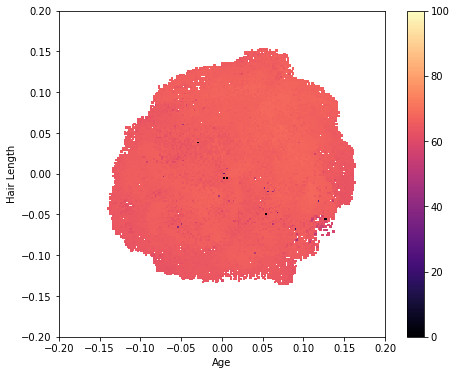

In [39]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, aspect="equal", vmin=0, vmax=100)
plt.xlabel("Age")
plt.ylabel("Hair Length");

## Creating a Collage of Celebrity Images

To view Tom Cruise images from across the archive, we can create a collage with the code below. First, we select images in a grid with measures spread across the archive.

In [77]:
import itertools

# Modify this to determine how many images to plot along each dimension.
img_freq = (
    8,  # Number of columns of images (i.e. along the "Age" axis).
    5,  # Number of rows of images (i.e. along the "Hair Length" axis).
) 

# List of images.
imgs =  []

# Convert archive to a df with solutions available.
df = result_archive.as_pandas(include_solutions=True)

# Compute the min and max measures for which solutions were found.
measure_bounds = [
    (round(df['measure_0'].min(), 2), round(df['measure_0'].max(), 2)),
    (round(df['measure_1'].min(), 2), round(df['measure_1'].max(), 2)),
]
delta_measure_0 = round((measure_bounds[0][1] - measure_bounds[0][0])/img_freq[0], 2)
delta_measure_1 = round((measure_bounds[1][1] - measure_bounds[1][0])/img_freq[1], 2)

for col, row in itertools.product(range(img_freq[1]), range(img_freq[0])):
    # Compute bounds of a box in measure space.
    measure_0_low = round(measure_bounds[0][0] + delta_measure_0*row, 2)
    measure_0_high = round(measure_bounds[0][0] + delta_measure_0*(row+1), 2)
    measure_1_low = round(measure_bounds[1][0] + delta_measure_1*col, 2)
    measure_1_high = round(measure_bounds[1][0] + delta_measure_1*(col+1), 2)

    # Query for a solution with measures within this box.
    query_string = (f"{measure_0_low} <= measure_0 & measure_0 <= {measure_0_high} & "
                    f"{measure_1_low} <= measure_1 & measure_1 <= {measure_1_high}")
    df_box = df.query(query_string)

    if not df_box.empty:
        # Select the solution with highest objective in the box.
        max_obj_idx = df_box['objective'].argmax()
        sol = df_box.loc[:, "solution_0":].iloc[max_obj_idx]

        # Convert the latent vector solution to an image.
        img = classifier.generate_image(np.array(sol))[0].cpu().detach()
        img = (img.clamp(-1, 1) + 1) / 2.0 # Normalize from [0,1]
        imgs.append(img)
    else:
        imgs.append(torch.zeros((3, 256, 256)))

Now, we plot the images as a single collage.

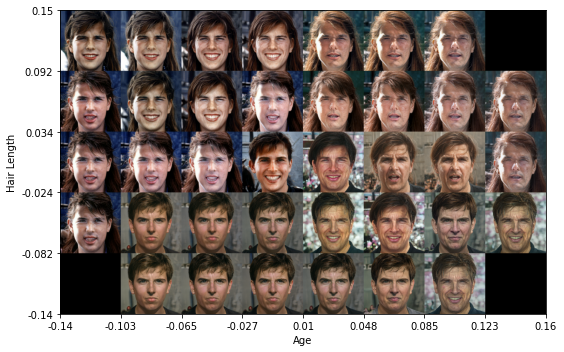

In [78]:
def create_archive_tick_labels(measure_range, num_ticks):
    low_pos = measure_range[0]
    high_pos = measure_range[1]

    delta = (measure_range[1]-measure_range[0])/num_ticks

    ticklabels = [
        round( delta*p + measure_range[0], 3)
        for p in range(num_ticks+1)
    ]
    return ticklabels

plt.figure(figsize=img_freq)
img_grid = make_grid(imgs, nrow=img_freq[0], padding=0)
img_grid = np.transpose(img_grid.cpu().numpy(), (1,2,0))
plt.imshow(img_grid)

plt.xlabel("Age")
num_x_ticks = img_freq[0]
x_ticklabels = create_archive_tick_labels( measure_bounds[0], num_x_ticks)
x_tick_range = img_grid.shape[1]
x_ticks = np.arange(0, x_tick_range+1e-9, step=x_tick_range/num_x_ticks)
plt.xticks(x_ticks, x_ticklabels)

plt.ylabel("Hair Length")
num_y_ticks = img_freq[1]
y_ticklabels = create_archive_tick_labels(measure_bounds[1], num_y_ticks)
y_ticklabels.reverse()
y_tick_range = img_grid.shape[0]
y_ticks = np.arange(0, y_tick_range+1e-9, step=y_tick_range/num_y_ticks)
plt.yticks(y_ticks, y_ticklabels)

plt.tight_layout()

## Conclusion

In this tutorial, we explored DQD algorithms with CMA-MAEGA. We showed how CMA-MAEGA is implemented in pyribs, and we used it to search for diverse images in a StyleGAN+CLIP pipeline. We created images of Tom Cruise while generating images varying in Age and Hair Length. We encourage you to experiment further by changing the prompts for both the objective and measures!

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_tom_cruise_dqd,
  title   = {Generating Tom Cruise Images with DQD Algorithms},
  author  = {Nivedit Reddy Balam and Bryon Tjanaka and David H. Lee and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2023},
  url     = {https://docs.pyribs.org/en/stable/tutorials/tom_cruise_dqd.html}
}
```